# Use of PSF simulations code

In [1]:
from simu_PSF_polarMFM import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm

from tqdm import tqdm

if you feed scalars, all the computation is performed with numpy, otherwise it uses pyTorch. The goal is that when using torch, all the variables are stored as tensors in the good device (cpu or gpu). 

In [2]:
#version = 'numpy'
version = 'torch'
device = 'cpu'

In [3]:
N_photons=5000 # number of photons collected 
N=80 # discretization of the BFP
l_pixel=16 #pixel size in micrometer
NA=1.4 # numerical aperture
mag=100 # first magnification
lambd=617 # wavelength in nm
f_tube=200 # tube lens focal in mm
MAG=200/150 # second magnification

if version == 'torch':
    N_photons=torch.tensor(N_photons, device=device)
    N=torch.tensor(N, device=device)
    l_pixel=torch.tensor(l_pixel, device=device)
    NA=torch.tensor(NA, device=device)
    mag=torch.tensor(mag, device=device)
    lambd=torch.tensor(lambd, device=device)
    f_tube=torch.tensor(f_tube, device=device)
    MAG=torch.tensor(MAG, device=device)

In [4]:
xp = 0. # dipole position in micrometer
yp = 0. # dipole position in micrometer
z = 3.*0.617 # z position of dipole in micrometer
d_ = -3.6*0.617/0.8+0.35 # defocus of dipole in micrometer
rho = 45 # equatorial angle in degree in degree
eta = 60 # azimuthal angle in degree in degree
delta = 80 # wobbling in degree

In [5]:
# this parameter allows to give a tensor of several inputs (the same number for all inputs)
# the PSF computation is parallelized and the output has one more dimension (the first)
several_psf = True
several_planes = True

if several_psf and version=='torch' and several_planes:
    xp = torch.tensor([xp for k in range(10)], device=device)
    yp = torch.tensor([yp for k in range(10)], device=device)
    z = torch.tensor([z for k in range(10)], device=device)
    d_ = torch.tensor([d_ for k in range(10)], device=device)
    rho = torch.tensor([rho for k in range(10)], device=device)
    eta = torch.tensor([eta for k in range(10)], device=device)
    delta = torch.tensor([delta for k in range(10)], device=device)
    second_plane = torch.tensor([0.3, 0, -0.3])
    polar_projections = torch.tensor([0, 45, 0])
    zernike_coefs_x = torch.zeros((3,15))
    zernike_coefs_y = torch.zeros((3,15))
    
elif several_psf and version=='torch':
    xp = torch.tensor([xp for k in range(10)], device=device)
    yp = torch.tensor([yp for k in range(10)], device=device)
    z = torch.tensor([z for k in range(10)], device=device)
    d_ = torch.tensor([d_ for k in range(10)], device=device)
    rho = torch.tensor([rho for k in range(10)], device=device)
    eta = torch.tensor([eta for k in range(10)], device=device)
    delta = torch.tensor([delta for k in range(10)], device=device)
    second_plane = None
    polar_projections = None
    zernike_coefs_x = torch.zeros(15)
    zernike_coefs_y = torch.zeros(15)

elif not several_psf and version=='torch':
    xp=torch.tensor(xp, device=device)
    yp=torch.tensor(yp, device=device)
    z=torch.tensor(z, device=device)
    d_=torch.tensor(d_, device=device)
    rho=torch.tensor(rho, device=device)
    eta=torch.tensor(eta, device=device)
    delta=torch.tensor(delta, device=device)
    second_plane = None
    polar_projections = None
    zernike_coefs_x = torch.zeros(15)
    zernike_coefs_y = torch.zeros(15)

else:
    second_plane = None
    polar_projections = None

In [6]:
# this functions essentially computes the BFP fields in the case of perfect focus emmited by a dpiole along x/y/z and projected on polarizations x/y
# x, y are meshgrids representing the BFP, distances renormalized by f_tube
# th1 and phi are the angles in the BFP
# r is the radius/f_tube in the BFP
# [Ex0, Ex1, Ex2] BFP fields from x/y/z dipoles projected on x
# [Ey0, Ey1, Ey2] BFP fields from x/y/z dipoles projected on y
# f_o is the objective focal to match the magnification

# THIS ONLY DEPENDS ON THE MICROSCOPE PARAMETERS AND IS GENERALLY COMPUTED ONCE ONLY

In [7]:
x, y, th1, phi, [Ex0, Ex1, Ex2], [Ey0, Ey1, Ey2], r, r_cut, k, f_o = vectorial_BFP_perfect_focus(N, NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, device='cpu')

C:\Users\LOCCO_Louise\AppData\Local\Temp\ipykernel_23216\3107150562.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  phase_mask=np.exp(1j*phi)


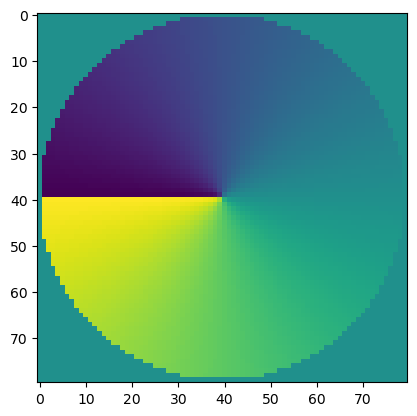

In [8]:
phase_mask=np.ones((N,N))
if device!='cpu':
    phase_mask=torch.exp(1j*phi)
else:
    phase_mask=np.exp(1j*phi)
phase_mask[x**2+y**2>r_cut**2]=1.
if device!='cpu':
    plt.imshow(np.angle(phase_mask.cpu()))
    plt.show()
else:
    plt.imshow(np.angle(phase_mask))
    plt.show()

if version=='torch':
    if several_planes==True:
        phase_mask = torch.stack([torch.ones((N,N), device=device), phase_mask, torch.ones((N,N), device=device)])
    else:
        phase_mask = torch.tensor(phase_mask, device=device)

# Basis function version

In [9]:
# u and v are meshgrids corresponding to the image plane coordinates
# M is the basis PSF matrix  --> see theoretical description

# THIS PART IS DEPENDANT ONTHE SPATIAL COORDINATES OF THE EMITTER AND THE FOCUS POSITION BUT NOT THE ORIENTATION

In [10]:
zernike_base = generate_zernike_base(r_cut=r_cut, N=N, zernike_order=4, device=device)

In [11]:
zernike_base.shape

torch.Size([15, 80, 80])

In [12]:
u, v, M = compute_M(xp=xp, yp=yp, zp=z, d=d_, x=x, y=y, th1=th1, phi=phi, Ex0=Ex0, Ex1=Ex1, Ex2=Ex2,
                    Ey0=Ey0, Ey1=Ey1, Ey2=Ey2, r=r, r_cut=r_cut, k=k, f_o=f_o,
                    phase_maskx=phase_mask, phase_masky=phase_mask, zernike_base=zernike_base, zernike_coefs_x=zernike_coefs_x, zernike_coefs_y=zernike_coefs_x,
                    second_plane=second_plane, polar_projections=polar_projections, N=N,
                    l_pixel=l_pixel, NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, MAG=MAG,
                   polar_offset=0., polar_offset2=0., BFP_version=False)

C:\Users\LOCCO_Louise\anaconda3\envs\amaury_env\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [30]:
M.shape

torch.Size([10, 3, 2, 3, 3, 154, 154])

In [31]:
M.dtype

torch.complex128

In [32]:
# HERE COMES THE ORIENTATION

In [33]:
psf = PSF(rho=rho, eta=eta, delta=delta, M=M, N_photons=N_photons)

In [16]:
psf.shape

torch.Size([10, 3, 2, 154, 154])

In [17]:
# the result is of dimension 3 (polar, x_image, y_image) or 4 if rho ... are tensors of dimension N (several psf computed)
# then the dimension is () (N, polar, x_image, y_image)

35.84477


C:\Users\LOCCO_Louise\AppData\Local\Temp\ipykernel_26232\275101500.py:44: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  secax = ax[0].secondary_xaxis('top', functions=(lambda x : 1000*x/(mag*MAG), lambda x : 0.001*mag*MAG*x))
C:\Users\LOCCO_Louise\AppData\Local\Temp\ipykernel_26232\275101500.py:45: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  secax2 = ax[0].secondary_yaxis('right', functions=(lambda x : 1000*x/(mag*MAG), lambda x : 0.001*mag*MAG*x))
C:\Users\LOCCO_Louise\AppData\Local\Temp\ipykernel_26232\275101500.py:56: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  secax = ax[1].secondary_xaxis('top', functions=(lambda x : 1000*x/(mag*MAG), lambda x : 0.001*mag*MAG*x))
C:\Users\LOCCO_Louise\AppData\Local\Temp\ip

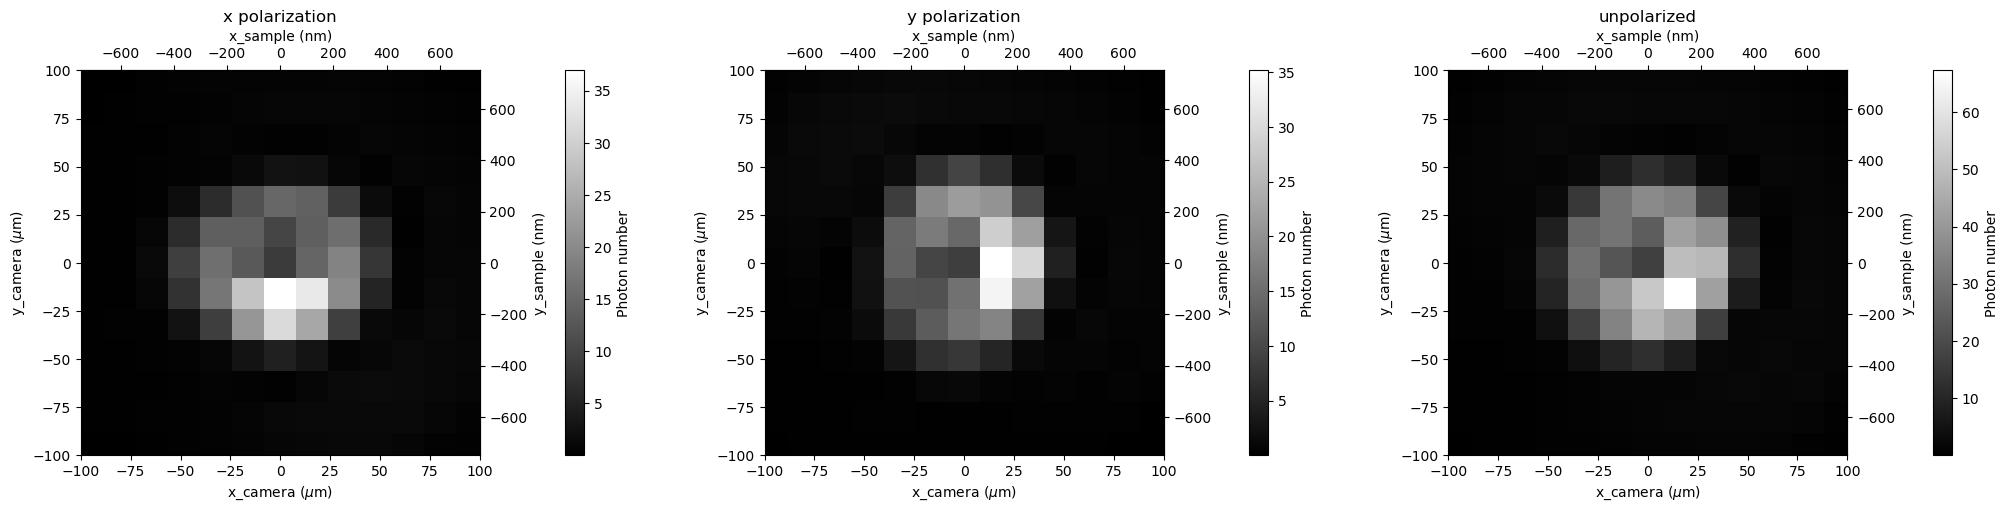

In [18]:
x_lim = 100
plt.rcParams['figure.figsize'] = [25, 5]
fig, ax = plt.subplots(1,3)
plan = 1

if isinstance(psf, torch.Tensor):
    if len(psf.shape)==3:
        psfx = psf[0].detach().numpy()
        psfy = psf[1].detach().numpy()
    elif len(psf.shape)==4:
        psfx = psf[0,0].detach().numpy()
        psfy = psf[0,1].detach().numpy()
    else:
        psfx = psf[0,plan,0].detach().numpy()
        psfy = psf[0,plan,1].detach().numpy()
    if xp.ndim!=0:
        xpp = xp[0]
        ypp = yp[0]
    else:
        xpp = xp
        ypp = yp
    psf_unpolarized = psfx+psfy
else:
    xpp = xp
    ypp = yp
    psfx = psf[0]
    psfy = psf[1]
    psf_unpolarized = psfx+psfy

if version=='numpy':
    maag = 0.001*(MAG*mag)
    r_circle = (0.61*lambd/NA)*maag
else:
    maag = 0.001*(MAG*mag).detach().numpy()
    r_circle = (0.61*lambd/NA).detach().numpy()*maag
print(r_circle)

mesh = ax[0].pcolormesh(u, v, psfx, cmap='gray')
ax[0].set_xlim((xpp*mag*MAG-x_lim, xpp*mag*MAG+x_lim))
ax[0].set_ylim((ypp*mag*MAG-x_lim, ypp*mag*MAG+x_lim))
ax[0].set_xlabel('x_camera ($\\mu$m)')
ax[0].set_ylabel('y_camera ($\\mu$m)')
ax[0].set_title('x polarization')
secax = ax[0].secondary_xaxis('top', functions=(lambda x : 1000*x/(mag*MAG), lambda x : 0.001*mag*MAG*x))
secax2 = ax[0].secondary_yaxis('right', functions=(lambda x : 1000*x/(mag*MAG), lambda x : 0.001*mag*MAG*x))
secax.set_xlabel('x_sample (nm)')
secax2.set_ylabel('y_sample (nm)')
cb = plt.colorbar(mesh, pad=0.15, label='Photon number')

mesh1 = ax[1].pcolormesh(u, v, psfy, cmap='gray')
ax[1].set_xlim((xpp*mag*MAG-x_lim, xpp*mag*MAG+x_lim))
ax[1].set_ylim((ypp*mag*MAG-x_lim, ypp*mag*MAG+x_lim))
ax[1].set_xlabel('x_camera ($\\mu$m)')
ax[1].set_ylabel('y_camera ($\\mu$m)')
ax[1].set_title('y polarization')
secax = ax[1].secondary_xaxis('top', functions=(lambda x : 1000*x/(mag*MAG), lambda x : 0.001*mag*MAG*x))
secax2 = ax[1].secondary_yaxis('right', functions=(lambda x : 1000*x/(mag*MAG), lambda x : 0.001*mag*MAG*x))
secax.set_xlabel('x_sample (nm)')
secax2.set_ylabel('y_sample (nm)')
cb = plt.colorbar(mesh1, pad=0.15, label='Photon number')

mesh2 = ax[2].pcolormesh(u, v, psf_unpolarized, cmap='gray')#, norm=LogNorm())
#ax[2].plot(xpp*(MAG*mag)+r_circle*np.cos(np.linspace(0,2*np.pi,100)), ypp*(MAG*mag)+r_circle*np.sin(np.linspace(0,2*np.pi,100)), c='r')
ax[2].set_xlim((xpp*mag*MAG-x_lim, xpp*mag*MAG+x_lim))
ax[2].set_ylim((ypp*mag*MAG-x_lim, ypp*mag*MAG+x_lim))
ax[2].set_xlabel('x_camera ($\\mu$m)')
ax[2].set_ylabel('y_camera ($\\mu$m)')
ax[2].set_title('unpolarized')
secax = ax[2].secondary_xaxis('top', functions=(lambda x : 1000*x/(mag*MAG), lambda x : 0.001*mag*MAG*x))
secax2 = ax[2].secondary_yaxis('right', functions=(lambda x : 1000*x/(mag*MAG), lambda x : 0.001*mag*MAG*x))
secax.set_xlabel('x_sample (nm)')
secax2.set_ylabel('y_sample (nm)')
cb = plt.colorbar(mesh2, pad=0.15, label='Photon number')
#ax[2].axvline(3000*0.1*200/150, c='r')

## BFP intensity

In [47]:
u, v, M_bfp = compute_M(xp=xp, yp=yp, zp=z, d=d_, x=x, y=y, th1=th1, phi=phi, Ex0=Ex0, Ex1=Ex1, Ex2=Ex2
                    , Ey0=Ey0, Ey1=Ey1, Ey2=Ey2, r=r, r_cut=r_cut, k=k, f_o=f_o, second_plane=None, N=N, l_pixel=l_pixel, NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, MAG=MAG,
                   aberrations=False, defocus_coef=1e-5, spherical_coef=-1.5, BFP_version=True)
bfp = BFP_intensity(rho=rho, eta=eta, delta=delta, M=M_bfp, N_photons=N_photons)

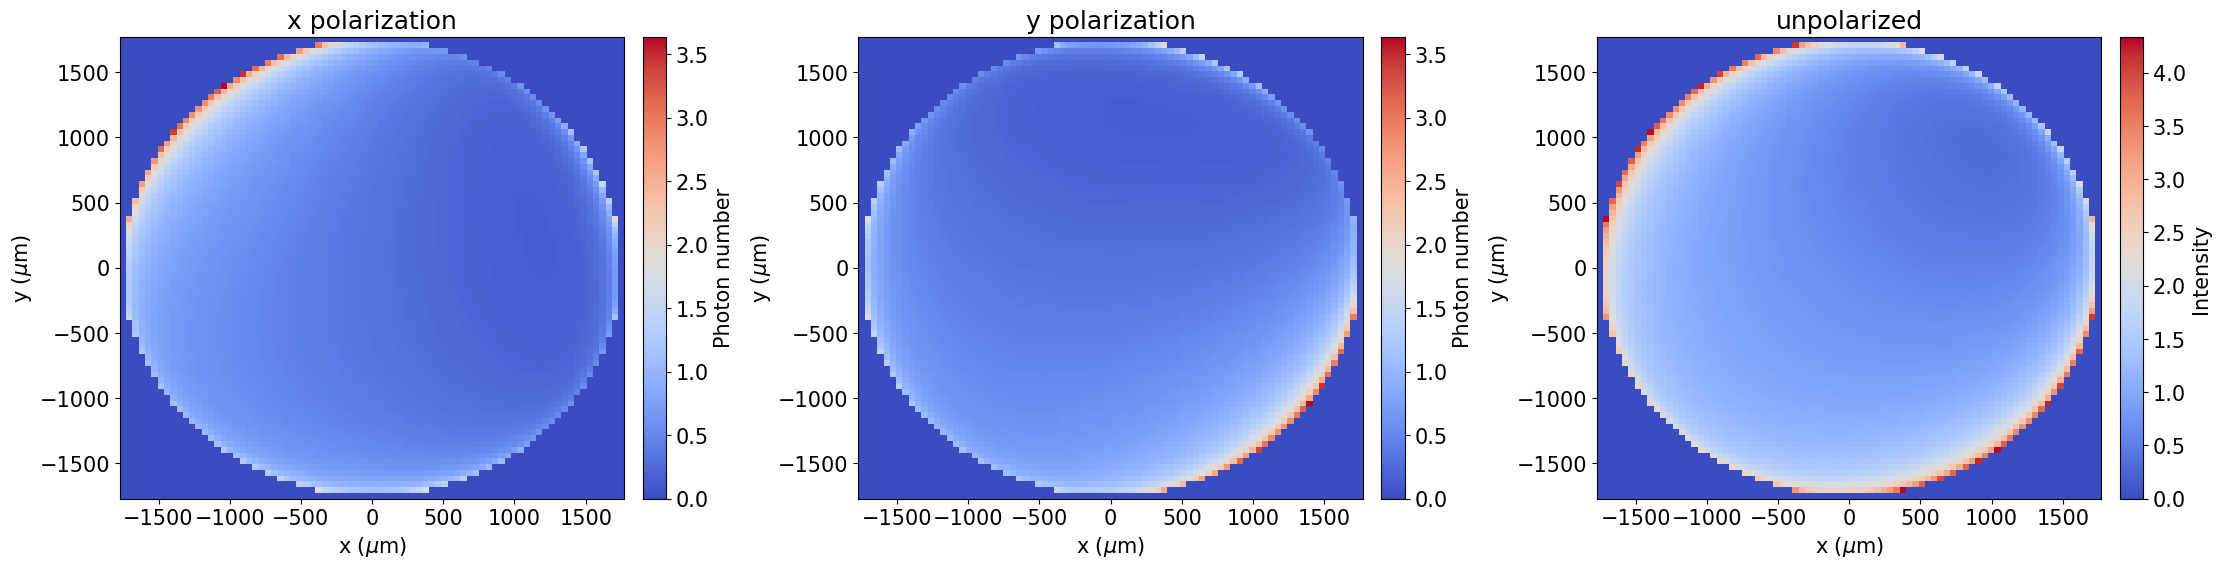

In [48]:
x_lim = 100
plt.rcParams['figure.figsize'] = [27, 6]
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(1,3)

if isinstance(bfp, torch.Tensor):
    if len(bfp.shape)==3:
        bfpx = bfp[0].detach().numpy()
        bfpy = bfp[1].detach().numpy()
    elif len(bfp.shape)==4:
        bfpx = bfp[0,0].detach().numpy()
        bfpy = bfp[0,1].detach().numpy()
    else:
        bfpx = bfp[0,1,0].detach().numpy()
        bfpy = bfp[0,1,1].detach().numpy()
    if xp.ndim!=0:
        xpp = xp[0]
        ypp = yp[0]
    bfp_unpolarized = bfpx+bfpy
else:
    xpp = xp
    ypp = yp
    bfpx = bfp[0]
    bfpy = bfp[1]
    bfp_unpolarized = bfpx+bfpy

mesh = ax[0].pcolormesh(f_o*x, f_o*y, bfpx, cmap='coolwarm')
ax[0].set_xlabel('x ($\\mu$m)')
ax[0].set_ylabel('y ($\\mu$m)')
ax[0].set_title('x polarization')
cb = plt.colorbar(mesh, pad=0.03, label='Photon number')

mesh1 = ax[1].pcolormesh(f_o*x, f_o*y, bfpy, cmap='coolwarm')
ax[1].set_xlabel('x ($\\mu$m)')
ax[1].set_ylabel('y ($\\mu$m)')
ax[1].set_title('y polarization')

cb = plt.colorbar(mesh1, pad=0.03, label='Photon number')

mesh2 = ax[2].pcolormesh(f_o*x, f_o*y, bfp_unpolarized, cmap='coolwarm')#, norm=LogNorm())
ax[2].set_xlabel('x ($\\mu$m)')
ax[2].set_ylabel('y ($\\mu$m)')
ax[2].set_title('unpolarized')
cb = plt.colorbar(mesh2, pad=0.03, label='Intensity')

## BFP phase

#### Warning, it is a false interpretation to consider that the BFP has a field that gives this intensity and phase. The intensity above resluts from a temporal integration (incoherent). All the component of this temporal sum have the following phase.

In [19]:
bfp_phase = BFP_phase(th1, phi, d_, xp, yp, z, r_cut, aberrations=False, defocus_coef=1e-5, spherical_coef=1e-5, N=N, NA=NA, mag=mag, lambd=lambd, f_tube=f_tube)

Function only in numpy case


35.84476591833215


ValueError: not enough values to unpack (expected 2, got 0)

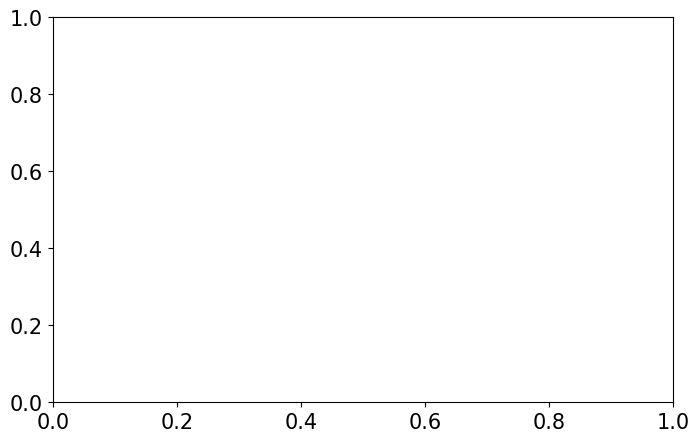

In [20]:
x_lim = 100
plt.rcParams['figure.figsize'] = [8, 5]
fig, ax = plt.subplots(1)

if isinstance(bfp_phase, torch.Tensor):
    if len(bfp_phase.shape)==3:
        bfp_phase = bfp_phase.detach().numpy()
    elif len(bfp.shape)==4:
        bfp_phase = bfp_phase[0].detach().numpy()
    else:
        bfp_phase = bfp_phase[0,0].detach().numpy()
    if xp.ndim!=0:
        xpp = xp[0]
        ypp = yp[0]
else:
    xpp = xp
    ypp = yp

if version=='numpy':
    maag = 0.001*(MAG*mag)
    r_circle = (0.61*lambd/NA)*maag
else:
    maag = 0.001*(MAG*mag).detach().numpy()
    r_circle = (0.61*lambd/NA).detach().numpy()*maag
print(r_circle)

mesh = ax.pcolormesh(x, y, bfp_phase, cmap='coolwarm')
ax.set_xlabel('x_camera ($\\mu$m)')
ax.set_ylabel('y_camera ($\\mu$m)')
ax.set_title('x polarization')
secax = ax.secondary_xaxis('top', functions=(lambda x : 1000*x/(mag*MAG), lambda x : 0.001*mag*MAG*x))
secax2 = ax.secondary_yaxis('right', functions=(lambda x : 1000*x/(mag*MAG), lambda x : 0.001*mag*MAG*x))
secax.set_xlabel('x_sample (nm)')
secax2.set_ylabel('y_sample (nm)')
cb = plt.colorbar(mesh, pad=0.15, label='Phase')

# Noise

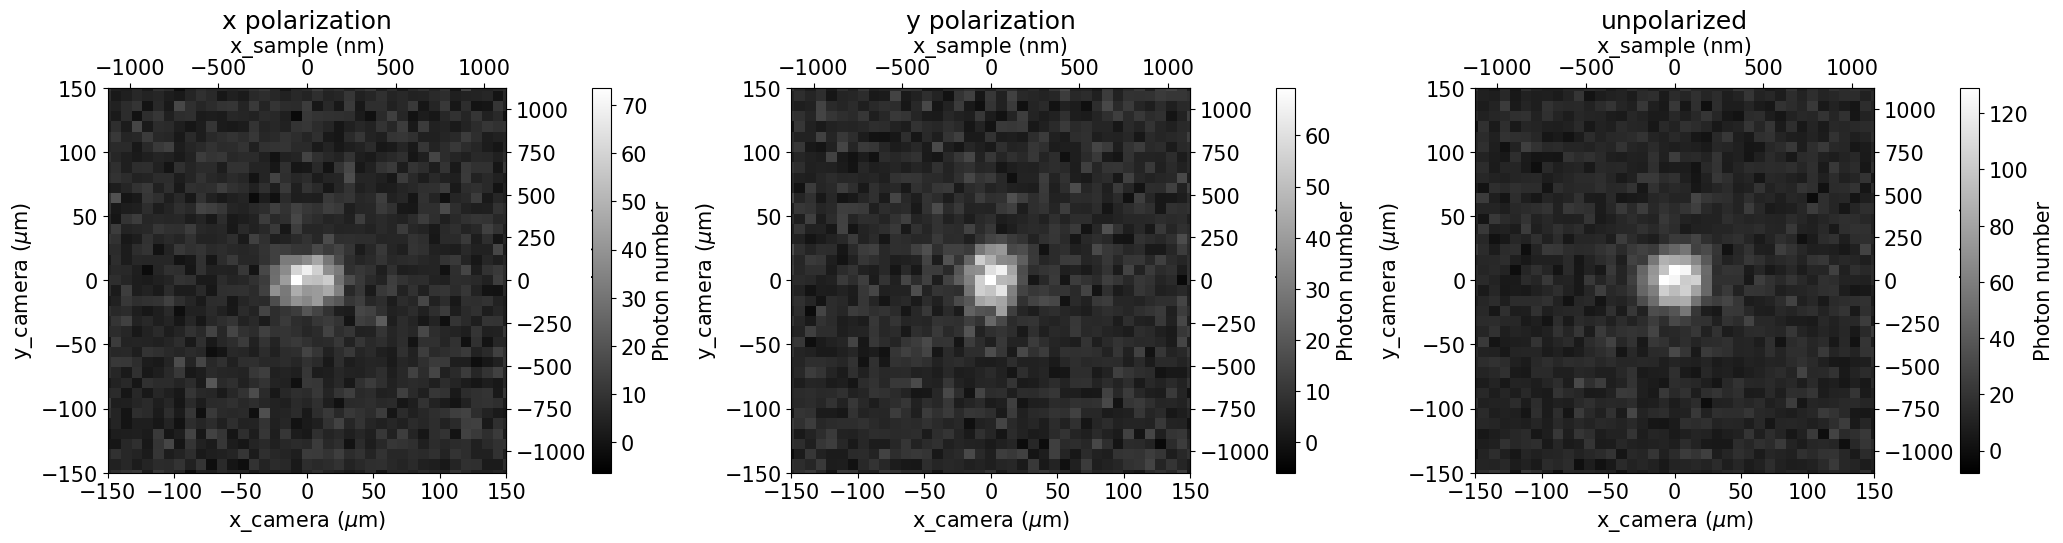

In [63]:
psf_0_noisy = noise(psfx, QE=1, EM=1, b=5., sigma_b=2., sigma_r=2., bias=1.)
psf_1_noisy = noise(psfy, QE=1, EM=1, b=5., sigma_b=2., sigma_r=2., bias=1.)

x_lim = 150
plt.rcParams['figure.figsize'] = [25, 5]
fig, ax = plt.subplots(1,3)

if isinstance(psf_0_noisy, torch.Tensor):
    psf_0_noisy = psf_0_noisy.detach().numpy()
    psf_1_noisy = psf_1_noisy.detach().numpy()

mesh = ax[0].pcolormesh(u, v, psf_0_noisy, cmap='gray')
ax[0].set_xlim((xpp*mag*MAG-x_lim, xpp*mag*MAG+x_lim))
ax[0].set_ylim((ypp*mag*MAG-x_lim, ypp*mag*MAG+x_lim))
ax[0].set_xlabel('x_camera ($\\mu$m)')
ax[0].set_ylabel('y_camera ($\\mu$m)')
ax[0].set_title('x polarization')
secax = ax[0].secondary_xaxis('top', functions=(lambda x : 1000*x/(mag*MAG), lambda x : 0.001*mag*MAG*x))
secax2 = ax[0].secondary_yaxis('right', functions=(lambda x : 1000*x/(mag*MAG), lambda x : 0.001*mag*MAG*x))
secax.set_xlabel('x_sample (nm)')
secax2.set_ylabel('y_sample (nm)')
cb = plt.colorbar(mesh, pad=0.15, label='Photon number')

mesh1 = ax[1].pcolormesh(u, v, psf_1_noisy, cmap='gray')
ax[1].set_xlim((xpp*mag*MAG-x_lim, xpp*mag*MAG+x_lim))
ax[1].set_ylim((ypp*mag*MAG-x_lim, ypp*mag*MAG+x_lim))
ax[1].set_xlabel('x_camera ($\\mu$m)')
ax[1].set_ylabel('y_camera ($\\mu$m)')
ax[1].set_title('y polarization')
secax = ax[1].secondary_xaxis('top', functions=(lambda x : 1000*x/(mag*MAG), lambda x : 0.001*mag*MAG*x))
secax2 = ax[1].secondary_yaxis('right', functions=(lambda x : 1000*x/(mag*MAG), lambda x : 0.001*mag*MAG*x))
secax.set_xlabel('x_sample (nm)')
secax2.set_ylabel('y_sample (nm)')
cb = plt.colorbar(mesh1, pad=0.15, label='Photon number')

mesh2 = ax[2].pcolormesh(u, v, psf_0_noisy+psf_1_noisy, cmap='gray')
ax[2].set_xlim((xpp*mag*MAG-x_lim, xpp*mag*MAG+x_lim))
ax[2].set_ylim((ypp*mag*MAG-x_lim, ypp*mag*MAG+x_lim))
ax[2].set_xlabel('x_camera ($\\mu$m)')
ax[2].set_ylabel('y_camera ($\\mu$m)')
ax[2].set_title('unpolarized')
secax = ax[2].secondary_xaxis('top', functions=(lambda x : 1000*x/(mag*MAG), lambda x : 0.001*mag*MAG*x))
secax2 = ax[2].secondary_yaxis('right', functions=(lambda x : 1000*x/(mag*MAG), lambda x : 0.001*mag*MAG*x))
secax.set_xlabel('x_sample (nm)')
secax2.set_ylabel('y_sample (nm)')
cb = plt.colorbar(mesh2, pad=0.15, label='Photon number')

# gaussian fit

In [ ]:
def gauss(coords, A, mu1, mu2, s, c):
    x, y = coords
    return (16**2)*A*(1/(2*np.pi*(s**2)))*np.exp(-0.5*(((x-mu1)**2+(y-mu2)**2)/((s**2)))) + c

In [ ]:
np.sum(psf_unpolarized)

In [ ]:
X = u.detach().numpy()
Y = v.detach().numpy()

In [ ]:
xdata = np.vstack((X.ravel(), Y.ravel()))
zdata = psf_unpolarized.ravel()

In [ ]:
p, pcov = curve_fit(gauss, xdata, zdata, p0=(1000, 15, 15, 35, 2))

In [ ]:
p

In [ ]:
sim = gauss((X, Y), p[0], p[1], p[2], p[3], p[4])

In [ ]:
print(np.sum(sim[sim.shape[0]//2-6:sim.shape[0]//2+7,sim.shape[0]//2-6:sim.shape[0]//2+7]))
print(np.sum(sim))
print(np.sum(psf_unpolarized[sim.shape[0]//2-6:sim.shape[0]//2+7,sim.shape[0]//2-6:sim.shape[0]//2+7]))
print(np.sum(psf_unpolarized))

In [ ]:
plt.rcParams['figure.figsize'] = [7, 5]
mee = plt.pcolormesh(u.detach().numpy(), v.detach().numpy(), sim)
plt.xlim((-200,200))
plt.ylim((-200,200))
cb = plt.colorbar(mee, pad=0.15, label='Photon number')
print(np.sum(sim))

# Focus

In [ ]:
nn = 150

In [ ]:
z_list = np.linspace(0.,100.,100)

In [ ]:
def fitting(xx, xx0, a, off):
    return a*(xx-xx0)**2+off

In [ ]:
def Gaussian2D_centered(xy, sigma, A):
    x, y = xy
    return A*np.exp(-(x**2)/(2*sigma**2) - (y**2)/(2*sigma**2))

In [ ]:
xi_list = []
for zz in tqdm(z_list):
    xp = torch.tensor([0. for i in range(nn)])
    yp = torch.tensor([0. for i in range(nn)])
    zp = torch.tensor([zz for i in range(nn)])
    rho = torch.tensor([50. for i in range(nn)])
    eta = torch.tensor([80. for i in range(nn)])
    delta = torch.tensor([160. for i in range(nn)])
    
    d = torch.tensor(np.linspace(-zz, -2*zz, nn))
    
    u, v, M = compute_M(xp=xp, yp=yp, zp=zp, d=d, x=x, y=y, th1=th1, phi=phi, Ex0=Ex0, Ex1=Ex1, Ex2=Ex2
                    , Ey0=Ey0, Ey1=Ey1, Ey2=Ey2, r=r, r_cut=r_cut, k=k, f_o=f_o, N=N, l_pixel=l_pixel, NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, MAG=MAG)
    psf_ = PSF(rho=rho, eta=eta, delta=delta, M=M, N_photons=N_photons).detach().numpy()
    psf_ = np.sum(psf_, axis=1)

    n = int(psf_.shape[-1]/2)
    index = np.argmax(np.sum(psf_[:,n-1:n+2, n-1:n+2], axis=(1,2)))    

    xi_list.append(zp.detach().numpy()[0]/(-d.detach().numpy()[index])) #int(p[0])

In [ ]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.scatter(z_list, xi_list)

In [ ]:
#z_lunit = [1,2,3,4,5,6,7,8,9,10,20,50,70,120]
#z = [0.617, 1.2340, 1.8510, 2.4680, 3.0850, 3.7020, 4.3190, 4.9360, 5.5530, 6.1700, 12.3400, 30.8500, 43.1900, 74.0400, 100.]
#xi_moi = [0.5896, 0.6385, 0.6683, 0.7135, 0.726446, 0.7413, 0.7347, 0.7569, 0.7418, 0.7515, 0.7637, 0.8121, 0.8173, 0.8286, 0.8355]
#xi_yan = [0.6230, 0.6431, 0.6500, 0.6701, 0.6689, 0.6796, 0.6874, 0.6933, 0.6900, 0.6952, 0.7128, 0.7247, 0.7331, 0.7398, 0.7433]
z = np.linspace(0.,100.,100)[1:]
xi_moi = [0.6234309623430963, 0.680365296803653, 0.6930232558139535, 0.7303921568627451, 0.7450000000000001, 0.7525252525252525, 0.7680412371134021, 0.7563451776649746, 0.7525252525252525, 0.772020725388601, 0.7883597883597884, 0.7680412371134021, 0.7925531914893618, 0.7883597883597885, 0.7801047120418848, 0.8054054054054054, 0.8010752688172043, 0.7801047120418848, 0.8010752688172044, 0.8010752688172043, 0.7883597883597883, 0.7842105263157895, 0.8142076502732241, 0.8054054054054054, 0.8097826086956522, 0.8054054054054054, 0.8010752688172043, 0.8232044198895028, 0.8142076502732241, 0.814207650273224, 0.8097826086956522, 0.8277777777777778, 0.8186813186813187, 0.8097826086956521, 0.8097826086956521, 0.8054054054054054, 0.8232044198895028, 0.8232044198895027, 0.8277777777777778, 0.8277777777777778, 0.8277777777777777, 0.8232044198895028, 0.8232044198895028, 0.8186813186813187, 0.8097826086956522, 0.8142076502732241, 0.8097826086956522, 0.8277777777777778, 0.8232044198895028, 0.8277777777777778, 0.8097826086956521, 0.8277777777777777, 0.8232044198895027, 0.8232044198895028, 0.8186813186813188, 0.8232044198895028, 0.8277777777777777, 0.8232044198895029, 0.8418079096045198, 0.8465909090909092, 0.8324022346368715, 0.8277777777777777, 0.8232044198895028, 0.8370786516853933, 0.8232044198895028, 0.8324022346368715, 0.8324022346368716, 0.8277777777777778, 0.8277777777777778, 0.8277777777777778, 0.8277777777777777, 0.8514285714285714, 0.8232044198895028, 0.8277777777777778, 0.8232044198895028, 0.8277777777777778, 0.8418079096045198, 0.8370786516853933, 0.8418079096045198, 0.8418079096045197, 0.8418079096045198, 0.8370786516853932, 0.8418079096045198, 0.8370786516853933, 0.8186813186813187, 0.8232044198895028, 0.8324022346368715, 0.8324022346368716, 0.8277777777777777, 0.8324022346368715, 0.8324022346368715, 0.8277777777777778, 0.8277777777777777, 0.8418079096045198, 0.8370786516853933, 0.8277777777777778, 0.8465909090909091, 0.8465909090909091, 0.8418079096045198]
xi_yan = [0.6394849785407726, 0.6592920353982301, 0.6772727272727272, 0.6834862385321101, 0.6930232558139534, 0.6962616822429906, 0.7028301886792453, 0.7028301886792453, 0.7061611374407584, 0.7095238095238094, 0.7129186602870814, 0.7163461538461539, 0.7129186602870813, 0.7163461538461539, 0.7198067632850241, 0.7233009708737864, 0.7233009708737863, 0.7198067632850241, 0.7163461538461537, 0.7303921568627452, 0.7268292682926829, 0.726829268292683, 0.726829268292683, 0.7233009708737863, 0.7268292682926829, 0.7303921568627451, 0.7303921568627452, 0.7339901477832512, 0.7303921568627451, 0.7268292682926829, 0.7376237623762375, 0.7339901477832512, 0.7303921568627451, 0.7268292682926829, 0.7339901477832512, 0.7303921568627451, 0.7376237623762376, 0.7339901477832512, 0.7376237623762376, 0.7339901477832512, 0.7339901477832512, 0.7339901477832512, 0.7339901477832512, 0.7376237623762376, 0.7339901477832512, 0.7412935323383085, 0.745, 0.7412935323383084, 0.7412935323383084, 0.7412935323383084, 0.7376237623762376, 0.7376237623762377, 0.7339901477832513, 0.7339901477832512, 0.7376237623762376, 0.7450000000000001, 0.7412935323383084, 0.7412935323383085, 0.7412935323383085, 0.7376237623762377, 0.7412935323383084, 0.7376237623762375, 0.745, 0.745, 0.7412935323383085, 0.7412935323383085, 0.7376237623762376, 0.7376237623762377, 0.745, 0.7412935323383084, 0.745, 0.7412935323383085, 0.7412935323383084, 0.7412935323383084, 0.7450000000000001, 0.745, 0.7412935323383084, 0.745, 0.745, 0.7450000000000001, 0.745, 0.745, 0.745, 0.745, 0.7412935323383085, 0.7412935323383084, 0.7412935323383084, 0.7412935323383084, 0.7412935323383084, 0.745, 0.745, 0.7487437185929648, 0.7487437185929647, 0.745, 0.7487437185929648, 0.745, 0.745, 0.745, 0.7487437185929647]

In [ ]:
n2/n1

In [ ]:
def fit(x, a, b, c):
    return a - (b/x)**c

In [ ]:
pp, ppcov = curve_fit(fit, np.array(z), xi_moi, p0=(0.8, 10, 0.2))

In [ ]:
pp

In [ ]:
epsilon = -(0.617)/(4*z*n2)

In [ ]:
mm = np.sqrt(n1**2-n2**2)

In [ ]:
xi_univ = (n2/n1)*(1-epsilon-(mm/n1)*np.sqrt(epsilon*(epsilon-2)))/(1-((n2/n1)**2)*epsilon*(2-epsilon))

In [ ]:
plt.rcParams['figure.figsize'] = [5, 3]
plt.scatter(z, np.array(xi_list)[:-1], marker='x', label='Simulated data')
plt.plot(z, xi_univ, c='r', label='Loginov $\\mathit{et}$ $\\mathit{al.}$ (2024) (analytical)')
#plt.plot(z, fit(np.array(z), pp[0], pp[1], pp[2]))
plt.scatter(z, xi_yan, label='Yan $\\mathit{et}$ $\\mathit{al.}$ (2019) (simulated)')
#plt.plot(z, [n2/n1 for k in range(len(z))], label='Geometrical optics', c='r')
plt.xlabel('Particule-interface distance z ($\\mu m$)')
plt.ylabel('$\\zeta = z/z_A$')
plt.xlim((0,101))
plt.ylim((0.5,0.87))
#plt.xlim((0,10))
plt.legend(loc='lower right')
plt.grid()

In [ ]:
np.arcsin(1.4/1.52)*180/np.pi